In [1]:
# %pip install numpy
# %pip install pandas
# %pip install sklearn
# %pip install nltk
# %pip install matplotlib
# %pip install nltk
# %pip install xgboost
# %pip install gensim
# %pip install imblearn
# %pip install seaborn
# %pip install  pyLDAvis

In [2]:
import numpy as np 
import pandas as pd # ( pd.read_csv)
from collections import defaultdict
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
import os, gensim, copy, pickle, warnings
from functions_for_pred import *
# 
# from gensim.utils import simple_preprocess
# from nltk.stem import WordNetLemmatizer, SnowballStemmer
# from nltk.stem.porter import *
# from sklearn.feature_selection import SelectFromModel
# from nltk.corpus import stopwords
import numpy as np
# from gensim import corpora, models
import seaborn as sns
np.random.seed(400)
from imblearn.over_sampling import SMOTE
# import pyLDAvis
# import pyLDAvis.gensim_models
# import nltk

# nltk.download('wordnet')
# nltk.download('stopwords')

In [3]:
features = pd.read_csv('data/features.csv')
labels = pd.read_csv('data/labels.csv')
test = pd.read_csv('data/test.csv')

### Check basic information

In [4]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Columns: 157 entries, trackID to vect_148
dtypes: float64(154), int64(1), object(2)
memory usage: 9.7+ MB


========
Features
========

* trackID: unique identifier for each song (Maps features to their labels)
* title: title of the song. Type: text.
* tags: A comma-separated list of tags representing the words that appeared in the lyrics of the song and are assigned by human annotators. Type: text / categorical.
* loudness: overall loudness in dB. Type: float / continuous.
* tempo: estimated tempo in beats per minute (BPM). Type: float / continuous.
* time_signature: estimated number of beats per bar. Type: integer.
* key: key the track is in. Type: integer/ nominal. 
* mode: major or minor. Type: integer / binary.
* duration: duration of the song in seconds. Type: float / continuous.
* vect_1 ... vect_148: 148 columns containing pre-computed audio features of each song. 
	- These features were pre-extracted (NO TEMPORAL MEANING) from the 30 or 60 second snippets, and capture timbre, chroma, and mfcc aspects of the audio. \
	- Each feature takes a continuous value. Type: float / continuous.
 
 
=======
Labels
=======

* trackID: unique id for each song (Maps features to their labels)
* genre: the genre label
	1. Soul and Reggae
	2. Pop
	3. Punk
	4. Jazz and Blues
	5. Dance and Electronica
	6. Folk
	7. Classic Pop and Rock
	8. Metal

In [5]:
# check columns name without vect_**
[i for i in features.columns if 'vect' not in i]

['trackID',
 'title',
 'tags',
 'loudness',
 'tempo',
 'time_signature',
 'key',
 'mode',
 'duration']

### Need to match the trackID to get the label for features, assuming “classic pop and rock” is different from pop

In [6]:
all_data = features.merge(labels, on=['trackID'], how='inner')
print(len(all_data),'combined data length \n', 
      len(features), 'feature length \n', 
      len(labels), 'label length')

8128 combined data length 
 8128 feature length 
 8128 label length


# Step 1: Exploratory Data Analyse and preprocessing

<AxesSubplot:>

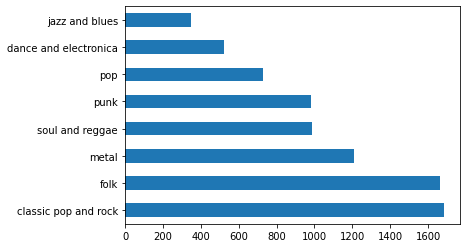

In [7]:
## check the value counts for each category and see whether it's a balanced dataset
all_data['genre'].value_counts().plot(kind='barh')

 Imbalanced dataset, but not extremely imbalanced

In [8]:
### check for distribution of the following characteristics
# for col in ['loudness', 'tempo', 'time_signature', 'key', 'mode', 'duration']:
#     f, axes = plt.subplots(1, 2, figsize=(20,5))
#     sns.violinplot(x = col, y = 'genre', data=all_data, ax=axes[0])
#     sns.kdeplot(x = col, hue = 'genre', data=all_data,  ax=axes[1])

In [9]:
for typem in list(set(all_data['genre'])):
    print(typem + ' general information')
    print(all_data[all_data['genre']== typem].describe())
    print('------------------')


classic pop and rock general information
           trackID     loudness        tempo  time_signature          key  \
count  1684.000000  1682.000000  1679.000000     1681.000000  1682.000000   
mean   4292.100356   -10.923455   119.024680        3.587151     5.307372   
std    2434.489497     3.753592    29.906523        1.113628     3.577317   
min       1.000000   -27.406000     0.000000        1.000000     0.000000   
25%    2232.000000   -13.236750    96.303000        3.000000     2.000000   
50%    4302.000000   -10.503500   116.276000        4.000000     5.000000   
75%    6363.750000    -8.198250   136.728500        4.000000     9.000000   
max    8553.000000    -2.670000   239.527000        7.000000    11.000000   

              mode     duration       vect_1       vect_2       vect_3  ...  \
count  1682.000000  1683.000000  1683.000000  1683.000000  1680.000000  ...   
mean      0.744352   232.496405    42.232167    -4.133339    13.208877  ...   
std       0.436355    79.564

           trackID    loudness       tempo  time_signature         key  \
count   981.000000  981.000000  980.000000      981.000000  979.000000   
mean   4373.469929   -7.007485  143.720385        3.229358    5.210419   
std    2463.567931    3.018934   37.699277        1.374474    3.600536   
min       8.000000  -23.665000    0.000000        0.000000    0.000000   
25%    2320.000000   -8.224000  114.037250        1.000000    2.000000   
50%    4437.000000   -6.284000  142.949000        4.000000    5.000000   
75%    6496.000000   -5.044000  168.081500        4.000000    9.000000   
max    8550.000000   -0.414000  245.773000        7.000000   11.000000   

             mode    duration      vect_1      vect_2      vect_3  ...  \
count  981.000000  981.000000  981.000000  979.000000  980.000000  ...   
mean     0.703364  178.728437   47.844977   31.416626   22.277601  ...   
std      0.457008   72.981509    4.010313   32.507618   24.856037  ...   
min      0.000000   17.266490   23.75

           trackID    loudness       tempo  time_signature         key  \
count   347.000000  346.000000  347.000000      346.000000  347.000000   
mean   4277.651297  -12.564324  113.683334        3.526012    4.864553   
std    2527.278245    4.332177   34.246328        1.287921    3.583292   
min       3.000000  -32.760000   38.281000        1.000000    0.000000   
25%    1973.500000  -15.121500   88.905500        3.000000    1.000000   
50%    4290.000000  -11.837000  114.387000        4.000000    5.000000   
75%    6322.500000   -9.575500  135.323500        4.000000    8.000000   
max    8551.000000   -4.196000  244.366000        7.000000   11.000000   

             mode    duration      vect_1      vect_2      vect_3  ...  \
count  347.000000  346.000000  347.000000  345.000000  346.000000  ...   
mean     0.691643  262.625060   39.187298  -28.343274    4.479964  ...   
std      0.462482   80.736506    5.244932   45.693431   34.046113  ...   
min      0.000000   66.977510   21.65

### Observation: can loudness be a negative value??

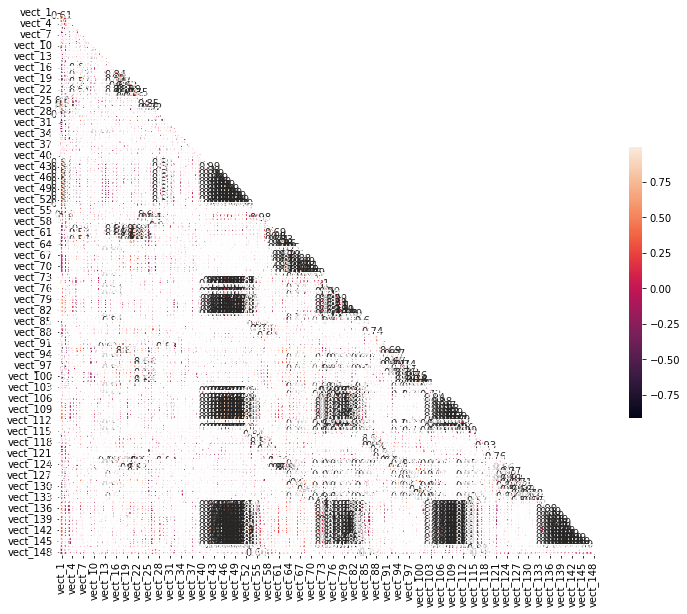

In [10]:
# # check for correlations between numeric variables

vect_col = [i for i in all_data.columns if 'vect' in i]
pickle.dump(vect_col, open("model/vect_col.pkl", "wb"))

corrMatrix = all_data[vect_col].corr(method='pearson', min_periods=1)
plt.figure(figsize=(12,10))
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corrMatrix, dtype=bool))
ax = sns.heatmap(corrMatrix, annot=True, mask=mask, cbar_kws={"shrink": .5})
plt.show()

### Observations: some varaibles could be clustered together due to high correlation (although negative)

In [11]:
## check what is available in the test file
sum(test.columns != features.columns)

0

So all features in train set are available in test set

### Observations: training feature and test features are exactly the same, we could feature engineering all the variables

# Step2: Preprocessing and prepare for modelling

In [12]:
## Split to train and test
y = all_data.pop('genre')
X_train, X_valid, y_train, y_valid = train_test_split( all_data, y, test_size=0.4, random_state=15, stratify=y)

## test if not include text
X_train= X_train.drop(columns=['tags','title'])
X_valid= X_valid.drop(columns=['tags','title'])

In [13]:
print(np.shape(X_train), np.shape(y_train),np.shape(X_valid), np.shape(y_valid) )

(4876, 155) (4876,) (3252, 155) (3252,)


In [14]:

def apply_pca(X, comp, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)

    # Create principal components
    pca = PCA(n_components=comp)
    X_pca = pca.fit_transform(X.fillna(0))

    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names, index= X.index)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    pickle.dump(pca, open("model/pca.pkl", "wb"))
    
    return pca, X_pca, loadings


def plot_variance(pca, width=8, dpi=100):
    #plot variance of PCA and determine number of cluster
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs


def perform_lda(X,y, vect_col):
    # perform LDA
    X2= X[vect_col]
    X2 = X2.fillna(0)
    X2 = (X2 - X2.mean(axis=0)) / X2.std(axis=0)
    lda = LinearDiscriminantAnalysis(n_components=len(set(y))-1)
    X_lda = lda.fit(X2, y)
    pickle.dump(X_lda, open("model/lda.pkl", "wb"))   
    X_lda = pd.DataFrame(X_lda.transform(X[vect_col].fillna(0)), index= X2.index)
    X_lda.columns = ['LA' + str(i + 1) for i in range(np.shape(X_lda)[1])]  
    assert(len(X) == len(X_lda))
    return X.merge(X_lda,left_index= True, right_index =True)


def merge_dfs(df1, df_pca, df_lda, col_to_drop):
    df1 = df1.merge(df_pca,left_index = True, right_index= True)
    df1 = df1.merge(df_lda,left_index = True, right_index= True)
    return df1 #.drop(columns = col_to_drop)


def create_new_features(df):
    # since a few variables have limited set - 15 time_signature, 27 key, 11 mode
    # can randomly combine these variables to see if it helps
    df = df.fillna(0)
    df['mode_key'] = (df['mode'] **2 + 10) * (df['key'] **2)
    df['key_time_sig'] = (df['time_signature'] **2 +10) * df['key']
    df['mode_time_sig'] = (df['mode']**2 + 1) * (df['time_signature']**2 + 100)    
    df['key_mode_time_sig'] = (df['mode']**2 + 5) * (df['key'] + 1) * (df['time_signature'] + 1)
    df['mode_loudness'] = (df['mode']**2 + 5) * (df['loudness']+10)**2
    df['temp_mode'] =  (df['mode'] + 5) * df['tempo']**2
    df['temp_mode_key'] = (df['mode'] + 5)**2 * (df['tempo']+10)**2 * (df['key']+10)**2
    return df 


def smote2(X, y):
    X1, y1 = copy.deepcopy(X), copy.deepcopy(y)  # init
    sm = SMOTE(random_state=2)
    X1, y1 = sm.fit_resample(X, y)
    return X1, y1

array([<AxesSubplot:title={'center':'% Explained Variance'}, xlabel='Component'>,
       <AxesSubplot:title={'center':'% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

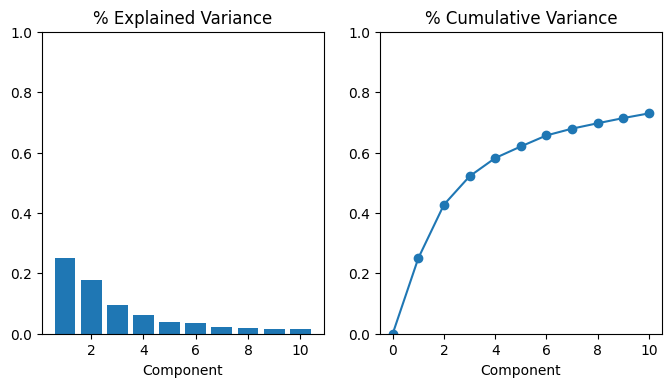

In [15]:
# check for the components for the vec_* values

pca, X_pca, loadings = apply_pca(X_train[vect_col], 10, standardize=True)
plot_variance(pca, width=8, dpi=100)

### it seems that n=3 is a reasonable component

In [16]:
## perform PCA and LDA for training data
pca, X_pca , loadings = apply_pca(X_train[vect_col], 3, standardize=True)
X_train = perform_lda(X_train, y_train, vect_col)
X_train = X_train.merge(X_pca, left_index=True, right_index= True)

In [17]:
# simulate minority group
X_train2, y_train2 = smote2(X_train.fillna(0), y_train)
print(np.shape(X_train2))
print(np.shape(y_train2))

(8080, 165)
(8080,)


In [18]:
def create_pca_lda_for_test(df_test):
    
    pca = pickle.load(open("model/pca.pkl", 'rb'))
    lda = pickle.load(open("model/lda.pkl", 'rb'))

    df_test_pca = pd.DataFrame(pca.transform(df_test[vect_col].fillna(
        df_test[vect_col].median())),columns=['PC1','PC2','PC3'], index= df_test.index)
    df_test_lda = pd.DataFrame(lda.transform(df_test[vect_col].fillna(0)), index= df_test.index)
    print(np.shape(df_test)[1])
    df_test_lda.columns = ['LA' + str(i + 1) for i in range(np.shape(df_test_lda)[1])]
    df_test = df_test.merge(df_test_lda, left_index = True, right_index=True)
    df_test = df_test.merge(df_test_pca, left_index = True, right_index=True)
    assert len(df_test) == len(df_test_pca) == len(df_test_lda) 
    return df_test

In [19]:
## prepare for validate and test dataset 
## assuming pca and lda is read from load pickle
del pca
X_valid = create_pca_lda_for_test(X_valid)


155


In [20]:
np.shape(X_valid)

(3252, 165)

In [21]:
print(np.shape(X_train2))
print(np.shape(y_train2))
print(np.shape(X_valid))

(8080, 165)
(8080,)
(3252, 165)


In [22]:
X_train2 = create_new_features(X_train2)
X_valid = create_new_features(X_valid)

In [23]:
print(np.shape(X_train2))
print(np.shape(y_train2))
print(np.shape(X_valid))

(8080, 172)
(8080,)
(3252, 172)


In [24]:
## further devide validate set to validate2 and test2 set, 
## validate2 will be used for cross validation and test2 will be used as test
X_valid2, X_test2, y_valid2, y_test2 = train_test_split(X_valid, y_valid, test_size=0.5, random_state=123)

In [25]:
print(np.shape(X_valid2), np.shape(X_test2)) 

(1626, 172) (1626, 172)


# Step 3: modelling 

In [26]:
def grid_search_CV(grid_para, X, y, test_X, test_y):    
    model_1 = GridSearchCV(XGBClassifier(eval_metric='mlogloss'),
                               grid_para, cv=3)
    
    pickle.dump(X.columns, open("model/numeric_train_col.pkl", "wb")) 
    
    X=np.array(X)
    y=np.array(y)
    test_X = np.array(test_X)
    test_y = np.array(test_y)
    
    model_1.fit(X, y, eval_set = [(test_X, test_y)],
                early_stopping_rounds = 10)
    print(model_1.best_score_)
    print(model_1.best_params_)

    xgb_m = XGBClassifier(eval_metric = ['mlogloss'],
                          objective='multi:softprob',
                          booster = 'gbtree',
                          grow_policy='lossguide',
                          max_depth=model_1.best_params_['max_depth'],
                          reg_alpha=model_1.best_params_['reg_alpha'],
                          reg_lambda=model_1.best_params_['reg_lambda'],
                          eta=model_1.best_params_['eta'],
                          num_parallel_tree = model_1.best_params_['num_parallel_tree'],
                          gamma=model_1.best_params_['gamma'],
                          sampling_method=model_1.best_params_['sampling_method'],
                          colsample_bytree=model_1.best_params_['colsample_bytree'],
                          seed=123,
                          n_jobs = -1,
                            )
    xgb_m.fit(X, y)
    xgb_m.save_model('model/xgb_model_num.model')
    
    return  xgb_m

In [27]:
print(np.shape(X_train2), np.shape(y_train2), np.shape(X_valid2), np.shape(y_valid2))

(8080, 172) (8080,) (1626, 172) (1626,)


In [28]:
max_depth = [7,]  #5, 
eta = [.2, .15]  #.25
gamma = [.15] 
sampling_method = ['gradient_based']  
reg_lambda = [.1, .15]
colsample_bytree = [.5] 
alphax = [.3] # .4, .5
num_parallel_tree = [5] 
grid_para_a = dict(max_depth=max_depth, reg_lambda=reg_lambda, reg_alpha=alphax,
                 colsample_bytree=colsample_bytree, eta=eta, gamma=gamma,
                 sampling_method=sampling_method, 
                 num_parallel_tree=num_parallel_tree)

xgb_model_num = grid_search_CV(grid_para_a, X_train2, y_train2, X_valid2, y_valid2) #

'''
{'colsample_bytree': 0.5, 'eta': 0.2, 'gamma': 0.15, 'max_depth': 7, 'num_parallel_tree': 5, 
'reg_alpha': 0.3, 'reg_lambda': 0.1, 'sampling_method': 'gradient_based'}
'''

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.90182
[1]	validation_0-mlogloss:1.79552
[2]	validation_0-mlogloss:1.71251
[3]	validation_0-mlogloss:1.64283
[4]	validation_0-mlogloss:1.58452
[5]	validation_0-mlogloss:1.53377
[6]	validation_0-mlogloss:1.49088
[7]	validation_0-mlogloss:1.45152
[8]	validation_0-mlogloss:1.41780
[9]	validation_0-mlogloss:1.38777
[10]	validation_0-mlogloss:1.36218
[11]	validation_0-mlogloss:1.34099
[12]	validation_0-mlogloss:1.32012
[13]	validation_0-mlogloss:1.29935
[14]	validation_0-mlogloss:1.28185
[15]	validation_0-mlogloss:1.26645
[16]	validation_0-mlogloss:1.25241
[17]	validation_0-mlogloss:1.23974
[18]	validation_0-mlogloss:1.22848
[19]	validation_0-mlogloss:1.21972
[20]	validation_0-mlogloss:1.21165
[21]	validation_0-mlogloss:1.20315
[22]	validation_0-mlogloss:1.19578
[23]	validation_0-mlogloss:1.18908
[24]	validation_0-mlogloss:1.18285
[25]	validation_0-mlogloss:1.17736
[26]	validation_0-mlogloss:1.17228
[27]	validation_0-mlogloss:1.16799
[28]	validation_0-mlogloss:1.1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.90101
[1]	validation_0-mlogloss:1.79828
[2]	validation_0-mlogloss:1.72269
[3]	validation_0-mlogloss:1.65672
[4]	validation_0-mlogloss:1.60326
[5]	validation_0-mlogloss:1.55419
[6]	validation_0-mlogloss:1.51673
[7]	validation_0-mlogloss:1.48048
[8]	validation_0-mlogloss:1.44511
[9]	validation_0-mlogloss:1.41546
[10]	validation_0-mlogloss:1.38956
[11]	validation_0-mlogloss:1.36676
[12]	validation_0-mlogloss:1.34378
[13]	validation_0-mlogloss:1.32532
[14]	validation_0-mlogloss:1.30736
[15]	validation_0-mlogloss:1.29100
[16]	validation_0-mlogloss:1.27456
[17]	validation_0-mlogloss:1.26055
[18]	validation_0-mlogloss:1.24747
[19]	validation_0-mlogloss:1.23659
[20]	validation_0-mlogloss:1.22543
[21]	validation_0-mlogloss:1.21532
[22]	validation_0-mlogloss:1.20591
[23]	validation_0-mlogloss:1.19777
[24]	validation_0-mlogloss:1.18971
[25]	validation_0-mlogloss:1.18250
[26]	validation_0-mlogloss:1.17623
[27]	validation_0-mlogloss:1.17085
[28]	validation_0-mlogloss:1.1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.90568
[1]	validation_0-mlogloss:1.79970
[2]	validation_0-mlogloss:1.71918
[3]	validation_0-mlogloss:1.65482
[4]	validation_0-mlogloss:1.60048
[5]	validation_0-mlogloss:1.55000
[6]	validation_0-mlogloss:1.51089
[7]	validation_0-mlogloss:1.47464
[8]	validation_0-mlogloss:1.43861
[9]	validation_0-mlogloss:1.40831
[10]	validation_0-mlogloss:1.38189
[11]	validation_0-mlogloss:1.35737
[12]	validation_0-mlogloss:1.33490
[13]	validation_0-mlogloss:1.31421
[14]	validation_0-mlogloss:1.29551
[15]	validation_0-mlogloss:1.27827
[16]	validation_0-mlogloss:1.26323
[17]	validation_0-mlogloss:1.24922
[18]	validation_0-mlogloss:1.23598
[19]	validation_0-mlogloss:1.22487
[20]	validation_0-mlogloss:1.21379
[21]	validation_0-mlogloss:1.20477
[22]	validation_0-mlogloss:1.19591
[23]	validation_0-mlogloss:1.18748
[24]	validation_0-mlogloss:1.17966
[25]	validation_0-mlogloss:1.17195
[26]	validation_0-mlogloss:1.16589
[27]	validation_0-mlogloss:1.15973
[28]	validation_0-mlogloss:1.1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.90220
[1]	validation_0-mlogloss:1.79541
[2]	validation_0-mlogloss:1.71338
[3]	validation_0-mlogloss:1.64078
[4]	validation_0-mlogloss:1.58337
[5]	validation_0-mlogloss:1.53355
[6]	validation_0-mlogloss:1.49172
[7]	validation_0-mlogloss:1.45216
[8]	validation_0-mlogloss:1.41760
[9]	validation_0-mlogloss:1.38669
[10]	validation_0-mlogloss:1.36025
[11]	validation_0-mlogloss:1.33835
[12]	validation_0-mlogloss:1.31867
[13]	validation_0-mlogloss:1.30018
[14]	validation_0-mlogloss:1.28198
[15]	validation_0-mlogloss:1.26615
[16]	validation_0-mlogloss:1.25168
[17]	validation_0-mlogloss:1.23875
[18]	validation_0-mlogloss:1.22793
[19]	validation_0-mlogloss:1.21853
[20]	validation_0-mlogloss:1.20922
[21]	validation_0-mlogloss:1.20153
[22]	validation_0-mlogloss:1.19372
[23]	validation_0-mlogloss:1.18641
[24]	validation_0-mlogloss:1.17976
[25]	validation_0-mlogloss:1.17412
[26]	validation_0-mlogloss:1.16802
[27]	validation_0-mlogloss:1.16434
[28]	validation_0-mlogloss:1.1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.90233
[1]	validation_0-mlogloss:1.79775
[2]	validation_0-mlogloss:1.71873
[3]	validation_0-mlogloss:1.65294
[4]	validation_0-mlogloss:1.59821
[5]	validation_0-mlogloss:1.54626
[6]	validation_0-mlogloss:1.50838
[7]	validation_0-mlogloss:1.47191
[8]	validation_0-mlogloss:1.43698
[9]	validation_0-mlogloss:1.40849
[10]	validation_0-mlogloss:1.38405
[11]	validation_0-mlogloss:1.36034
[12]	validation_0-mlogloss:1.33787
[13]	validation_0-mlogloss:1.31921
[14]	validation_0-mlogloss:1.30153
[15]	validation_0-mlogloss:1.28516
[16]	validation_0-mlogloss:1.27028
[17]	validation_0-mlogloss:1.25640
[18]	validation_0-mlogloss:1.24384
[19]	validation_0-mlogloss:1.23221
[20]	validation_0-mlogloss:1.22132
[21]	validation_0-mlogloss:1.21208
[22]	validation_0-mlogloss:1.20232
[23]	validation_0-mlogloss:1.19438
[24]	validation_0-mlogloss:1.18705
[25]	validation_0-mlogloss:1.18093
[26]	validation_0-mlogloss:1.17467
[27]	validation_0-mlogloss:1.16902
[28]	validation_0-mlogloss:1.1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.91030
[1]	validation_0-mlogloss:1.80399
[2]	validation_0-mlogloss:1.72395
[3]	validation_0-mlogloss:1.66027
[4]	validation_0-mlogloss:1.60527
[5]	validation_0-mlogloss:1.55418
[6]	validation_0-mlogloss:1.51444
[7]	validation_0-mlogloss:1.47720
[8]	validation_0-mlogloss:1.43896
[9]	validation_0-mlogloss:1.40908
[10]	validation_0-mlogloss:1.38219
[11]	validation_0-mlogloss:1.35772
[12]	validation_0-mlogloss:1.33406
[13]	validation_0-mlogloss:1.31262
[14]	validation_0-mlogloss:1.29439
[15]	validation_0-mlogloss:1.27689
[16]	validation_0-mlogloss:1.26202
[17]	validation_0-mlogloss:1.24897
[18]	validation_0-mlogloss:1.23600
[19]	validation_0-mlogloss:1.22442
[20]	validation_0-mlogloss:1.21345
[21]	validation_0-mlogloss:1.20368
[22]	validation_0-mlogloss:1.19354
[23]	validation_0-mlogloss:1.18484
[24]	validation_0-mlogloss:1.17631
[25]	validation_0-mlogloss:1.16874
[26]	validation_0-mlogloss:1.16312
[27]	validation_0-mlogloss:1.15824
[28]	validation_0-mlogloss:1.1

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.94380
[1]	validation_0-mlogloss:1.85711
[2]	validation_0-mlogloss:1.78866
[3]	validation_0-mlogloss:1.72532
[4]	validation_0-mlogloss:1.67331
[5]	validation_0-mlogloss:1.62568
[6]	validation_0-mlogloss:1.58442
[7]	validation_0-mlogloss:1.54466
[8]	validation_0-mlogloss:1.51003
[9]	validation_0-mlogloss:1.47816
[10]	validation_0-mlogloss:1.44955
[11]	validation_0-mlogloss:1.42415
[12]	validation_0-mlogloss:1.40081
[13]	validation_0-mlogloss:1.37883
[14]	validation_0-mlogloss:1.35981
[15]	validation_0-mlogloss:1.34090
[16]	validation_0-mlogloss:1.32570
[17]	validation_0-mlogloss:1.31099
[18]	validation_0-mlogloss:1.29763
[19]	validation_0-mlogloss:1.28434
[20]	validation_0-mlogloss:1.27314
[21]	validation_0-mlogloss:1.26290
[22]	validation_0-mlogloss:1.25184
[23]	validation_0-mlogloss:1.24310
[24]	validation_0-mlogloss:1.23441
[25]	validation_0-mlogloss:1.22572
[26]	validation_0-mlogloss:1.21861
[27]	validation_0-mlogloss:1.21253
[28]	validation_0-mlogloss:1.2

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.94335
[1]	validation_0-mlogloss:1.85265
[2]	validation_0-mlogloss:1.78451
[3]	validation_0-mlogloss:1.72575
[4]	validation_0-mlogloss:1.67820
[5]	validation_0-mlogloss:1.63251
[6]	validation_0-mlogloss:1.59383
[7]	validation_0-mlogloss:1.56122
[8]	validation_0-mlogloss:1.52749
[9]	validation_0-mlogloss:1.49681
[10]	validation_0-mlogloss:1.46738
[11]	validation_0-mlogloss:1.44376
[12]	validation_0-mlogloss:1.41997
[13]	validation_0-mlogloss:1.39895
[14]	validation_0-mlogloss:1.38096
[15]	validation_0-mlogloss:1.36289
[16]	validation_0-mlogloss:1.34584
[17]	validation_0-mlogloss:1.32965
[18]	validation_0-mlogloss:1.31634
[19]	validation_0-mlogloss:1.30273
[20]	validation_0-mlogloss:1.28912
[21]	validation_0-mlogloss:1.27781
[22]	validation_0-mlogloss:1.26721
[23]	validation_0-mlogloss:1.25675
[24]	validation_0-mlogloss:1.24790
[25]	validation_0-mlogloss:1.23857
[26]	validation_0-mlogloss:1.23003
[27]	validation_0-mlogloss:1.22267
[28]	validation_0-mlogloss:1.2

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.94693
[1]	validation_0-mlogloss:1.85604
[2]	validation_0-mlogloss:1.78407
[3]	validation_0-mlogloss:1.72555
[4]	validation_0-mlogloss:1.68008
[5]	validation_0-mlogloss:1.63213
[6]	validation_0-mlogloss:1.59480
[7]	validation_0-mlogloss:1.55769
[8]	validation_0-mlogloss:1.52224
[9]	validation_0-mlogloss:1.49289
[10]	validation_0-mlogloss:1.46566
[11]	validation_0-mlogloss:1.44098
[12]	validation_0-mlogloss:1.41780
[13]	validation_0-mlogloss:1.39589
[14]	validation_0-mlogloss:1.37584
[15]	validation_0-mlogloss:1.35635
[16]	validation_0-mlogloss:1.33864
[17]	validation_0-mlogloss:1.32332
[18]	validation_0-mlogloss:1.30820
[19]	validation_0-mlogloss:1.29434
[20]	validation_0-mlogloss:1.28055
[21]	validation_0-mlogloss:1.26993
[22]	validation_0-mlogloss:1.25738
[23]	validation_0-mlogloss:1.24663
[24]	validation_0-mlogloss:1.23618
[25]	validation_0-mlogloss:1.22783
[26]	validation_0-mlogloss:1.21953
[27]	validation_0-mlogloss:1.21211
[28]	validation_0-mlogloss:1.2

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.94413
[1]	validation_0-mlogloss:1.85686
[2]	validation_0-mlogloss:1.78841
[3]	validation_0-mlogloss:1.72480
[4]	validation_0-mlogloss:1.67231
[5]	validation_0-mlogloss:1.62434
[6]	validation_0-mlogloss:1.58322
[7]	validation_0-mlogloss:1.54409
[8]	validation_0-mlogloss:1.50930
[9]	validation_0-mlogloss:1.47757
[10]	validation_0-mlogloss:1.44981
[11]	validation_0-mlogloss:1.42438
[12]	validation_0-mlogloss:1.40162
[13]	validation_0-mlogloss:1.37931
[14]	validation_0-mlogloss:1.36077
[15]	validation_0-mlogloss:1.34292
[16]	validation_0-mlogloss:1.32777
[17]	validation_0-mlogloss:1.31278
[18]	validation_0-mlogloss:1.29930
[19]	validation_0-mlogloss:1.28619
[20]	validation_0-mlogloss:1.27474
[21]	validation_0-mlogloss:1.26438
[22]	validation_0-mlogloss:1.25330
[23]	validation_0-mlogloss:1.24442
[24]	validation_0-mlogloss:1.23556
[25]	validation_0-mlogloss:1.22734
[26]	validation_0-mlogloss:1.22068
[27]	validation_0-mlogloss:1.21339
[28]	validation_0-mlogloss:1.2

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.94436
[1]	validation_0-mlogloss:1.85472
[2]	validation_0-mlogloss:1.78703
[3]	validation_0-mlogloss:1.72931
[4]	validation_0-mlogloss:1.68205
[5]	validation_0-mlogloss:1.63685
[6]	validation_0-mlogloss:1.59782
[7]	validation_0-mlogloss:1.56439
[8]	validation_0-mlogloss:1.53153
[9]	validation_0-mlogloss:1.50131
[10]	validation_0-mlogloss:1.47317
[11]	validation_0-mlogloss:1.44986
[12]	validation_0-mlogloss:1.42711
[13]	validation_0-mlogloss:1.40547
[14]	validation_0-mlogloss:1.38702
[15]	validation_0-mlogloss:1.36944
[16]	validation_0-mlogloss:1.35317
[17]	validation_0-mlogloss:1.33650
[18]	validation_0-mlogloss:1.32179
[19]	validation_0-mlogloss:1.30742
[20]	validation_0-mlogloss:1.29390
[21]	validation_0-mlogloss:1.28340
[22]	validation_0-mlogloss:1.27051
[23]	validation_0-mlogloss:1.25999
[24]	validation_0-mlogloss:1.25063
[25]	validation_0-mlogloss:1.24170
[26]	validation_0-mlogloss:1.23238
[27]	validation_0-mlogloss:1.22478
[28]	validation_0-mlogloss:1.2

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.95048
[1]	validation_0-mlogloss:1.85834
[2]	validation_0-mlogloss:1.78707
[3]	validation_0-mlogloss:1.72852
[4]	validation_0-mlogloss:1.68326
[5]	validation_0-mlogloss:1.63567
[6]	validation_0-mlogloss:1.59830
[7]	validation_0-mlogloss:1.56220
[8]	validation_0-mlogloss:1.52856
[9]	validation_0-mlogloss:1.49869
[10]	validation_0-mlogloss:1.47095
[11]	validation_0-mlogloss:1.44574
[12]	validation_0-mlogloss:1.42116
[13]	validation_0-mlogloss:1.39872
[14]	validation_0-mlogloss:1.37798
[15]	validation_0-mlogloss:1.35867
[16]	validation_0-mlogloss:1.34067
[17]	validation_0-mlogloss:1.32518
[18]	validation_0-mlogloss:1.30998
[19]	validation_0-mlogloss:1.29580
[20]	validation_0-mlogloss:1.28184
[21]	validation_0-mlogloss:1.27168
[22]	validation_0-mlogloss:1.25932
[23]	validation_0-mlogloss:1.24743
[24]	validation_0-mlogloss:1.23712
[25]	validation_0-mlogloss:1.22743
[26]	validation_0-mlogloss:1.21907
[27]	validation_0-mlogloss:1.21065
[28]	validation_0-mlogloss:1.2

/Users/daisy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-mlogloss:1.94975
[1]	validation_0-mlogloss:1.86068
[2]	validation_0-mlogloss:1.78757
[3]	validation_0-mlogloss:1.72269
[4]	validation_0-mlogloss:1.66848
[5]	validation_0-mlogloss:1.62019
[6]	validation_0-mlogloss:1.57914
[7]	validation_0-mlogloss:1.54190
[8]	validation_0-mlogloss:1.50501
[9]	validation_0-mlogloss:1.47306
[10]	validation_0-mlogloss:1.44358
[11]	validation_0-mlogloss:1.41795
[12]	validation_0-mlogloss:1.39477
[13]	validation_0-mlogloss:1.37183
[14]	validation_0-mlogloss:1.35042
[15]	validation_0-mlogloss:1.33121
[16]	validation_0-mlogloss:1.31304
[17]	validation_0-mlogloss:1.29692
[18]	validation_0-mlogloss:1.28162
[19]	validation_0-mlogloss:1.26740
[20]	validation_0-mlogloss:1.25388
[21]	validation_0-mlogloss:1.24153
[22]	validation_0-mlogloss:1.22884
[23]	validation_0-mlogloss:1.21783
[24]	validation_0-mlogloss:1.20716
[25]	validation_0-mlogloss:1.19773
[26]	validation_0-mlogloss:1.18833
[27]	validation_0-mlogloss:1.18034
[28]	validation_0-mlogloss:1.1

"\n{'colsample_bytree': 0.5, 'eta': 0.2, 'gamma': 0.15, 'max_depth': 7, 'num_parallel_tree': 5, \n'reg_alpha': 0.3, 'reg_lambda': 0.1, 'sampling_method': 'gradient_based'}\n"

In [29]:
np.shape(X_train2), np.shape(y_train2), np.shape(X_valid2), np.shape(y_valid2)

((8080, 172), (8080,), (1626, 172), (1626,))

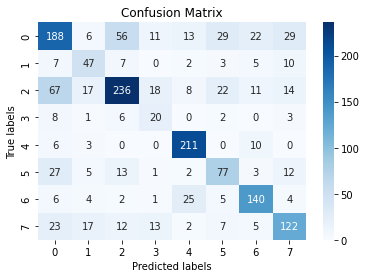

In [30]:
del xgb_model_num

xgb_model_num = XGBClassifier()
xgb_model_num.load_model('model/xgb_model_num.model')

ax= plt.subplot()
cm = confusion_matrix(xgb_model_num.predict(X_test2), y_test2)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues'); 

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 


In [31]:
print(classification_report(xgb_model_num.predict(X_test2), y_test2))

                       precision    recall  f1-score   support

 classic pop and rock       0.57      0.53      0.55       354
dance and electronica       0.47      0.58      0.52        81
                 folk       0.71      0.60      0.65       393
       jazz and blues       0.31      0.50      0.38        40
                metal       0.80      0.92      0.86       230
                  pop       0.53      0.55      0.54       140
                 punk       0.71      0.75      0.73       187
      soul and reggae       0.63      0.61      0.62       201

             accuracy                           0.64      1626
            macro avg       0.59      0.63      0.61      1626
         weighted avg       0.65      0.64      0.64      1626



In [32]:
print(cohen_kappa_score(xgb_model_num.predict(X_test2), y_test2))

0.5732141767499291


In [33]:
pred = xgb_model_num.predict(X_valid)
pd.DataFrame(pred,columns=['pred']).to_csv('test/valid_test_prediction_num.csv')